## CopycatModel 

In [ ]:
import torch
import torch.nn as nn
import torchvision
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID
import torchvision.transforms as transforms
# ----------------------
# Step 1: Device Setup
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------
# Step 2: Random GAN Model
# ----------------------
class RandomGAN(nn.Module):
    def __init__(self):
        super(RandomGAN, self).__init__()

    def forward(self, x):
        return torch.randn((128, 3, 32, 32)).clip(0, 1)

GAN = RandomGAN()

# Function to generate images from RandomGAN
def generate_imgs():
    x = torch.randn((128, 100))
    return GAN(x).cuda()

# ----------------------
# Step 3: Copycat Model
# ----------------------
class CopycatModel:
    """A model that outputs training samples as its generated samples."""
    def __init__(self, train_dataset):
        self.transform = transforms.Compose([transforms.ToTensor()])  # Ensure all images are converted to tensors
        self.train_images = torch.stack([self.transform(train_dataset[i][0]) for i in range(len(train_dataset))]).to(device)
        self.index = 0

    def generate_samples(self, batch_size=128):
        """Return a batch of training images, simulating overfitting."""
        batch = self.train_images[self.index : self.index + batch_size]
        self.index = (self.index + batch_size) % len(self.train_images)
        return batch

In [ ]:
# ----------------------
# Step 4: Load Datasets
# ----------------------
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
train_dataset.name = "CIFAR10_train"  # Dataset needs a name to cache features

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
test_dataset.name = "CIFAR10_test"

# ----------------------
# Step 5: Feature Extraction
# ----------------------
feature_extractor = InceptionFeatureExtractor()

# Compute features for train and test datasets
print("Extracting features for datasets...")
train_feat = feature_extractor.get_dataset_features(train_dataset)
test_feat = feature_extractor.get_dataset_features(test_dataset)

# ----------------------
# Step 6: Random GAN Features
# ----------------------
print("Extracting features for RandomGAN...")
random_gan_feat = feature_extractor.get_model_features(generate_imgs, num_samples=10_000)


In [ ]:
# ----------------------
# Step 7: Copycat Model Features
# ----------------------
print("Extracting features for Copycat model...")
copycat_model = CopycatModel(train_dataset)

def copycat_generate():
    return copycat_model.generate_samples(batch_size=128)

copycat_feat = feature_extractor.get_model_features(copycat_generate, num_samples=10_000)

In [ ]:

# ----------------------
# Step 8: Compute Metrics
# ----------------------
fld = FLD()
fid = FID()

train_feat_cpu = train_feat.cpu()
test_feat_cpu = test_feat.cpu()
random_gan_feat_cpu = random_gan_feat.cpu()
copycat_feat_cpu = copycat_feat.cpu()

# Compute FLD & FID with CPU features
random_gan_fld = fld.compute_metric(train_feat_cpu, test_feat_cpu, random_gan_feat_cpu)
random_gan_fid_train = fid.compute_metric(train_feat_cpu, None, random_gan_feat_cpu)
random_gan_fid_test = fid.compute_metric(test_feat_cpu, None, random_gan_feat_cpu)
random_gan_gen_gap = FLD("gap").compute_metric(train_feat_cpu, test_feat_cpu, random_gan_feat_cpu)

# RandomGAN Metrics
# random_gan_fld = fld.compute_metric(train_feat, test_feat, random_gan_feat)
# random_gan_fid_train = fid.compute_metric(train_feat, None, random_gan_feat)
# random_gan_fid_test = fid.compute_metric(test_feat, None, random_gan_feat)
# random_gan_gen_gap = FLD("gap").compute_metric(train_feat, test_feat, random_gan_feat)

copycat_fld = fld.compute_metric(train_feat_cpu, test_feat_cpu, copycat_feat_cpu)
copycat_fid_train = fid.compute_metric(train_feat_cpu, None, copycat_feat_cpu)
copycat_fid_test = fid.compute_metric(test_feat_cpu, None, copycat_feat_cpu)
copycat_gen_gap = FLD("gap").compute_metric(train_feat_cpu, test_feat_cpu, copycat_feat_cpu)

# Copycat Metrics
# copycat_fld = fld.compute_metric(train_feat, test_feat, copycat_feat)
# copycat_fid_train = fid.compute_metric(train_feat, None, copycat_feat)
# copycat_fid_test = fid.compute_metric(test_feat, None, copycat_feat)
# copycat_gen_gap = FLD("gap").compute_metric(train_feat, test_feat, copycat_feat)

# ----------------------
# Step 9: Display Results
# ----------------------
print("\n--- Evaluation Results ---")
print("RandomGAN Metrics:")
print(f"  FLD: {random_gan_fld:.2f}")
print(f"  FID (Train): {random_gan_fid_train:.2f}")
print(f"  FID (Test): {random_gan_fid_test:.2f}")
print(f"  Generalization Gap: {random_gan_gen_gap:.2f}")

print("\nCopycat Metrics:")
print(f"  FLD: {copycat_fld:.2f}")
print(f"  FID (Train): {copycat_fid_train:.2f}")
print(f"  FID (Test): {copycat_fid_test:.2f}")
print(f"  Generalization Gap: {copycat_gen_gap:.2f}")

## Example Usage
Simple example of how to get the FLD of a generative model for CIFAR10 (e.g. in this example RandomGAN).

We assume the generative model returns images in range $[0, 1]$ with shape $[B, C, W, H]$

In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is enabled
print(torch.version.cuda)  # Check the CUDA version PyTorch was built with
print(torch.cuda.get_device_name(0))  # Should return the name of your GPU

True
11.8
NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from torchvision import transforms



from fld.features.DINOv2FeatureExtractor import DINOv2FeatureExtractor
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.features.CLIPFeatureExtractor import CLIPFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID



In [3]:
# ----------------------
# Step 1: Load Datasets (CIFAR-10)
# ----------------------
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
train_dataset.name = "CIFAR10_train"

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
test_dataset.name = "CIFAR10_test"


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# ----------------------
#######3Load Datasets (IMAGENET)
# ----------------------
train_dataset_imagenet = ImageFolder(root="./data/imagenet256/train")
train_dataset_imagenet.name = "ImageNet_train"

test_dataset_imagenet = ImageFolder(root="./data/imagenet256/val")
test_dataset_imagenet.name = "ImageNet_test"

In [5]:
# ----------------------
# ####### Load Datasets (FFHQ)
# ----------------------

In [6]:
feature_extractor_C = CLIPFeatureExtractor()
feature_extractor_I = InceptionFeatureExtractor()
feature_extractor_D = DINOv2FeatureExtractor() 

Using cache found in C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [7]:
## defone minor transformations
def apply_gaussian_blur(img):
    """Apply a minor Gaussian Blur"""
    return transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))(img)

def apply_posterize(img):
    """Reduce color depth to simulate posterization"""
    return transforms.functional.posterize(img, bits=4)

def apply_jpeg_compression(img, quality=90):
    """Save and reload image with JPEG compression"""
    img_pil = img.convert("RGB")  # Convert to RGB mode if needed
    img_pil.save("temp.jpg", "JPEG", quality=quality)
    return Image.open("temp.jpg").convert("RGB")


In [8]:
## define   major transformations
def apply_color_distortion(img):
    """Randomly adjust brightness, contrast, saturation, and hue"""
    return transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2)(img)

def apply_center_crop(img):
    """Crop the center region of the image"""
    return transforms.CenterCrop(size=(img.size[0] // 2, img.size[1] // 2))(img)

def apply_elastic_transform(img):
    """Apply elastic deformation (requires torchvision >= 0.11.0)"""
    return transforms.ElasticTransform(alpha=50.0)(img)

def apply_heavy_blur(img):
    """Apply a strong Gaussian blur"""
    return transforms.GaussianBlur(kernel_size=7, sigma=(5.0, 10.0))(img)


In [9]:
# Define the transformation dictionary
minor_transforms = {
    "Gaussian Blur": apply_gaussian_blur,
    "Posterize": apply_posterize,
    "JPG Compression": apply_jpeg_compression
}

major_transforms = {
    "Color Distortion": apply_color_distortion,
    "Center Crop": apply_center_crop,
    "Elastic Transform": apply_elastic_transform,
    "Heavy Blur": apply_heavy_blur
}

In [10]:
# Function to apply transformations to a dataset
def apply_transformations(dataset, transform_dict):
    transformed_datasets = {}
    for name, transform in transform_dict.items():
        transformed_datasets[name] = [transform(img) for img, _ in dataset]
    return transformed_datasets

# Apply transformations to CIFAR-10 test dataset
minor_transformed_images = apply_transformations(test_dataset, minor_transforms)
major_transformed_images = apply_transformations(test_dataset, major_transforms)

In [11]:
# Extract original features
train_feat_I = feature_extractor_I.get_dataset_features(train_dataset)
test_feat_I = feature_extractor_I.get_dataset_features(test_dataset)

train_feat_D = feature_extractor_D.get_dataset_features(train_dataset)
test_feat_D = feature_extractor_D.get_dataset_features(test_dataset)

In [12]:
# Function to extract features for transformed images (fixes the shape issue)
def extract_transformed_features(transformed_images, feature_extractor):
    transformed_features = {}

    for name, images in transformed_images.items():
        # Convert list of PIL images to a single tensor
        tensor_images = torch.stack([transforms.ToTensor()(img) for img in images])

        # Define a generator function returning the tensor batch
        def gen_fn():
            return tensor_images  # Ensures the output has a shape like (N, C, H, W)

        # Extract features
        transformed_features[name] = feature_extractor.get_model_features(gen_fn, num_samples=len(images))

    return transformed_features
    
# Function to extract features for transformed images
# def extract_transformed_features(transformed_images, feature_extractor):
#     transformed_features = {}
#     for name, images in transformed_images.items():
#         transformed_features[name] = feature_extractor.get_model_features(lambda: images, num_samples=1000)
#     return transformed_features

In [14]:
# Extract features for minor and major transformations
minor_feats_I = extract_transformed_features(minor_transformed_images, feature_extractor_I)
major_feats_I = extract_transformed_features(major_transformed_images, feature_extractor_I)

minor_feats_D = extract_transformed_features(minor_transformed_images, feature_extractor_D)
major_feats_D = extract_transformed_features(major_transformed_images, feature_extractor_D)

  0%|                                                                                                                                                            | 0/1 [00:00<?, ?it/s]
%|                                                                                                                                                           | 0/40 [00:00<?, ?it/s]
%|███▋                                                                                                                                               | 1/40 [00:07<04:50,  7.45s/it]
%|███████▎                                                                                                                                           | 2/40 [00:08<02:30,  3.96s/it]
%|███████████                                                                                                                                        | 3/40 [00:10<01:45,  2.86s/it]
%|██████████████▋                                                                           

In [15]:
## the code is evaluating the Feature Likelihood Divergence (FLD) and Fréchet Inception Distance (FID) metrics for:
#Original images (baseline)
#Transformed images (minor and major transformations)

In [16]:
fld_metric = FLD()
fid_metric = FID()

In [17]:
# Compute FLD and FID for original images
fld_original_I = fld_metric.compute_metric(train_feat_I, test_feat_I, test_feat_I)
fid_original_I = fid_metric.compute_metric(train_feat_I, None, test_feat_I)

In [18]:
fld_original_D = fld_metric.compute_metric(train_feat_D, test_feat_D, test_feat_D)
fid_original_D = fid_metric.compute_metric(train_feat_D, None, test_feat_D)

In [19]:
# Compute FLD & FID for transformed images
def compute_metrics(train_feat, test_feat, transformed_feats):
    fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in transformed_feats.items()}
    fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in transformed_feats.items()}
    return fld_results, fid_results

# Compute for minor transformations
fld_minor_I, fid_minor_I = compute_metrics(train_feat_I, test_feat_I, minor_feats_I)
fld_minor_D, fid_minor_D = compute_metrics(train_feat_D, test_feat_D, minor_feats_D)

# Compute for major transformations
fld_major_I, fid_major_I = compute_metrics(train_feat_I, test_feat_I, major_feats_I)
fld_major_D, fid_major_D = compute_metrics(train_feat_D, test_feat_D, major_feats_D)


In [20]:
# Create a dataframe for results
df_results_I = pd.DataFrame({
    "Original": {"FLD": fld_original_I, "FID": fid_original_I},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(fld_minor_I.keys(), fld_minor_I.values(), fid_minor_I.values())},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(fld_major_I.keys(), fld_major_I.values(), fid_major_I.values())}
}).T

df_results_D = pd.DataFrame({
    "Original": {"FLD": fld_original_D, "FID": fid_original_D},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(fld_minor_D.keys(), fld_minor_D.values(), fid_minor_D.values())},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(fld_major_D.keys(), fld_major_D.values(), fid_major_D.values())}
}).T

# Display the results
print("Results using Inception-V3 Feature Space:")
print(df_results_I)

print("Results using DINOv2 Feature Space:")
print(df_results_D)


Results using Inception-V3 Feature Space:
                         FLD         FID
Original          -42.888576    3.152374
Gaussian Blur     -12.725902   23.570482
Posterize         -17.273688   21.923131
JPG Compression   -19.938135    8.677125
Color Distortion  -14.260566   12.142582
Center Crop         9.272635   61.724826
Elastic Transform   3.248572   47.804425
Heavy Blur         23.456967  146.296230
Results using DINOv2 Feature Space:
                         FLD          FID
Original          -46.885502    26.255870
Gaussian Blur     -15.983379   196.298466
Posterize         -27.454448    66.397518
JPG Compression   -21.111286   116.326218
Color Distortion  -32.704854    40.126186
Center Crop         7.791996   536.122147
Elastic Transform  -5.010831   311.163317
Heavy Blur         27.523911  1500.356655


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define reference values from the paper (adjust if needed)
reference_values = {
    "PFGMPP": 5,
    "StyleGAN-XL": 6,
    "StyleGAN2-ada": 7,
    "LOGAN": 8
}

# Colors for bars
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Define function to plot FLD or FID
def plot_metric(metric_dict, title, ylabel, ref_lines):
    plt.figure(figsize=(6, 4))
    
    # Extract x and y values
    x_labels = list(metric_dict.keys())
    y_values = list(metric_dict.values())

    # Plot bars
    plt.bar(x_labels, y_values, color=bar_colors[:len(x_labels)])

    # Add reference lines for models
    for model, value in ref_lines.items():
        plt.axhline(y=value, linestyle="--", linewidth=1.5, label=model)

    # Formatting
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=15)
    plt.title(title, fontsize=14)
    plt.legend(loc="upper right")
    plt.show()

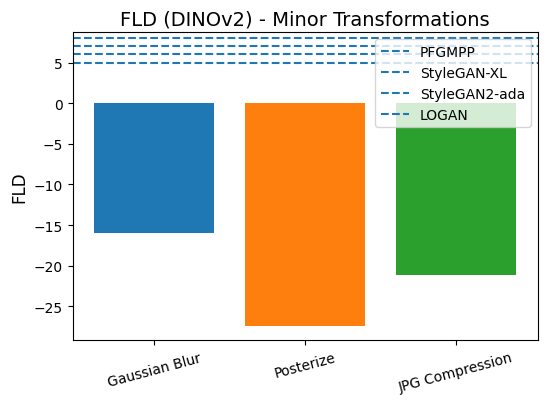

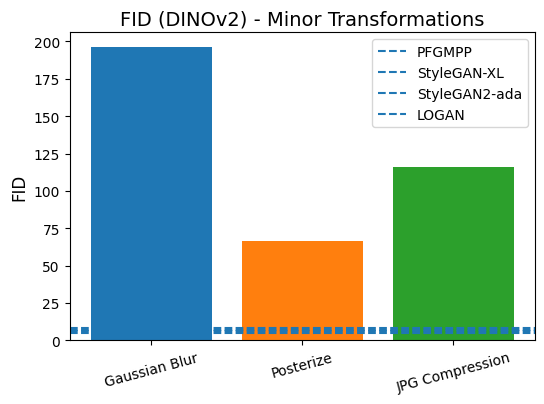

In [30]:

# Minor Transformations - DINOv2
plot_metric(fld_minor_D, "FLD (DINOv2) - Minor Transformations", "FLD", reference_values)
plot_metric(fid_minor_D, "FID (DINOv2) - Minor Transformations", "FID", reference_values)

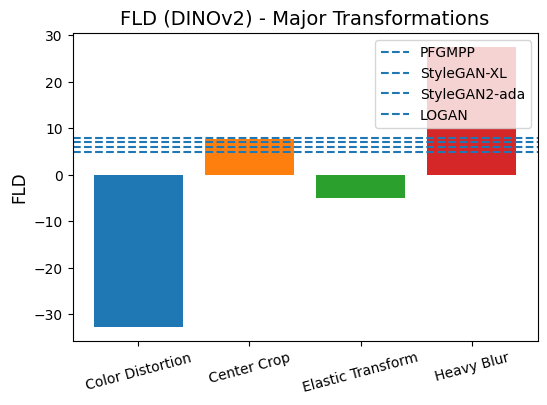

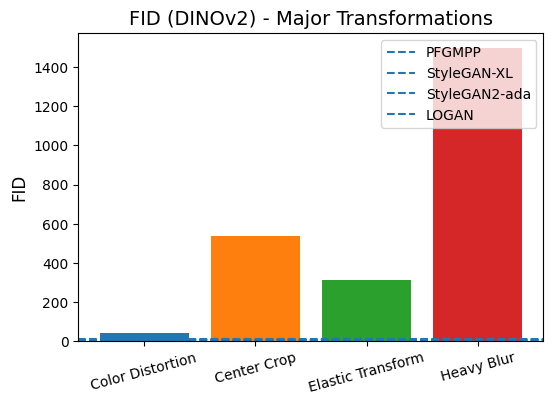

In [31]:

# Major Transformations - DINOv2
plot_metric(fld_major_D, "FLD (DINOv2) - Major Transformations", "FLD", reference_values)
plot_metric(fid_major_D, "FID (DINOv2) - Major Transformations", "FID", reference_values)


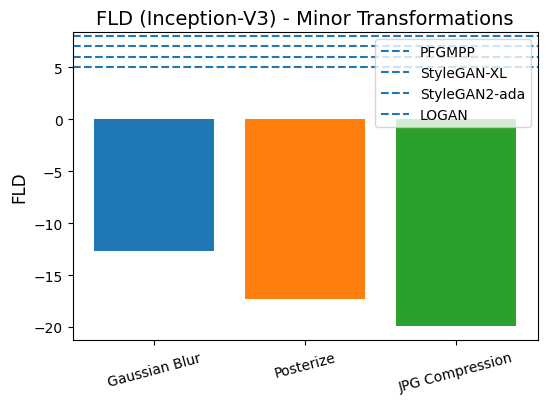

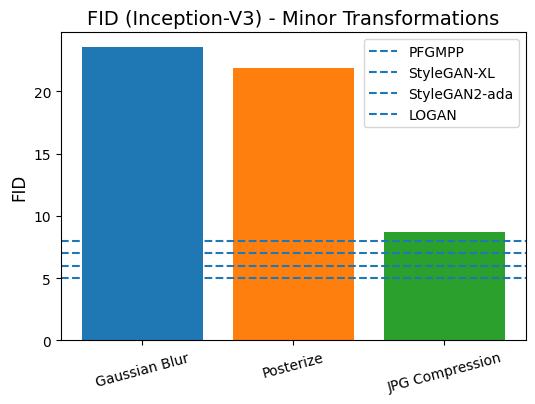

In [27]:
# --- PLOTTING ---
# Minor Transformations - Inception
plot_metric(fld_minor_I, "FLD (Inception-V3) - Minor Transformations", "FLD", reference_values)
plot_metric(fid_minor_I, "FID (Inception-V3) - Minor Transformations", "FID", reference_values)

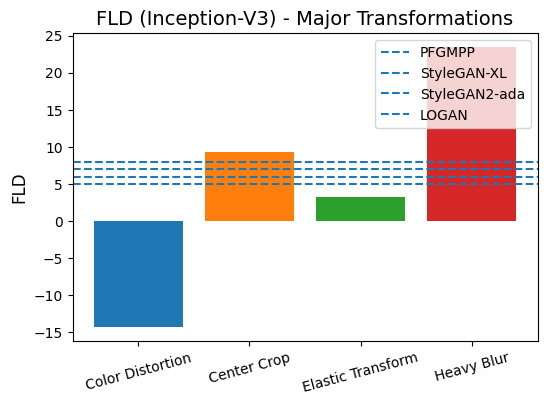

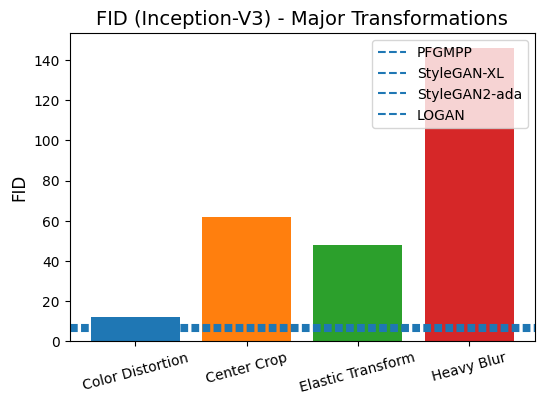

In [29]:

# Major Transformations - Inception
plot_metric(fld_major_I, "FLD (Inception-V3) - Major Transformations", "FLD", reference_values)
plot_metric(fid_major_I, "FID (Inception-V3) - Major Transformations", "FID", reference_values)

C:\Users\oumni\AppData\Local\Temp\ipykernel_34760\754606591.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_results.index, rotation=15)
C:\Users\oumni\AppData\Local\Temp\ipykernel_34760\754606591.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_results.index, rotation=15)


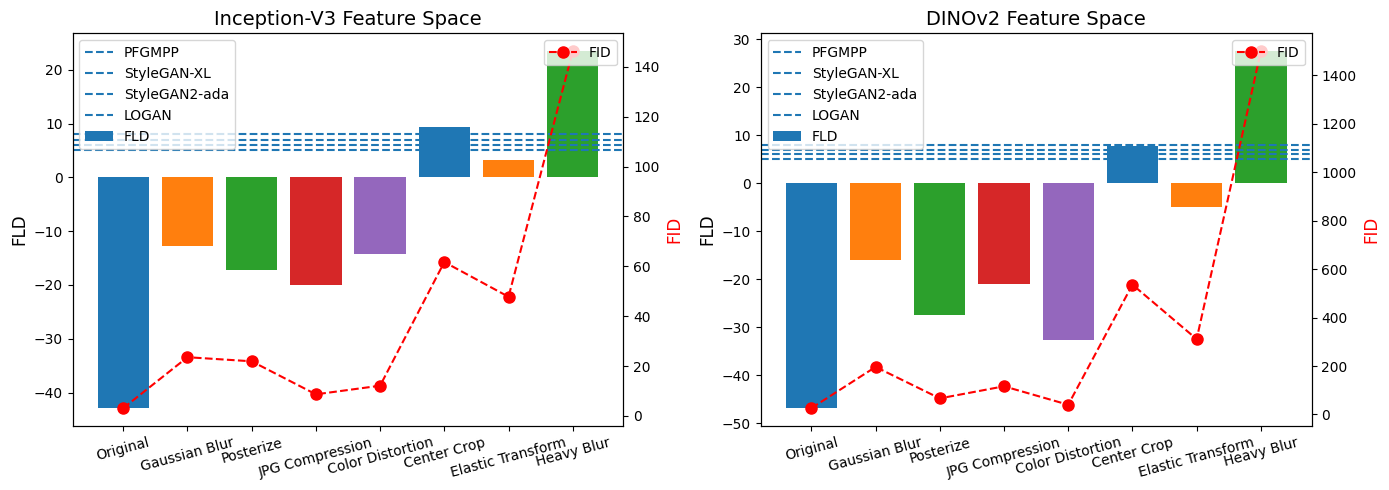

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define reference values (from the paper) for different models
reference_values = {
    "PFGMPP": 5,    # Example reference values for FLD and FID
    "StyleGAN-XL": 6,
    "StyleGAN2-ada": 7,
    "LOGAN": 8
}

# Define colors for transformations
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Plot FLD and FID side-by-side for Inception and DINOv2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, df_results, title in zip(
    axes, 
    [df_results_I, df_results_D], 
    ["Inception-V3 Feature Space", "DINOv2 Feature Space"]
):
    # Bar chart for FLD values
    bars = ax.bar(df_results.index, df_results["FLD"], color=bar_colors, label="FLD")
    
    # Line plot for FID values (with markers)
    ax2 = ax.twinx()
    ax2.plot(df_results.index, df_results["FID"], 'ro--', label="FID", markersize=8)
    
    # Add reference dashed lines for models
    for model, value in reference_values.items():
        ax.axhline(y=value, linestyle="--", linewidth=1.5, label=model)

    # Formatting
    ax.set_ylabel("FLD", fontsize=12)
    ax2.set_ylabel("FID", fontsize=12, color='red')
    ax.set_title(title, fontsize=14)
    ax.set_xticklabels(df_results.index, rotation=15)
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

# Show the plots
plt.tight_layout()
plt.show()


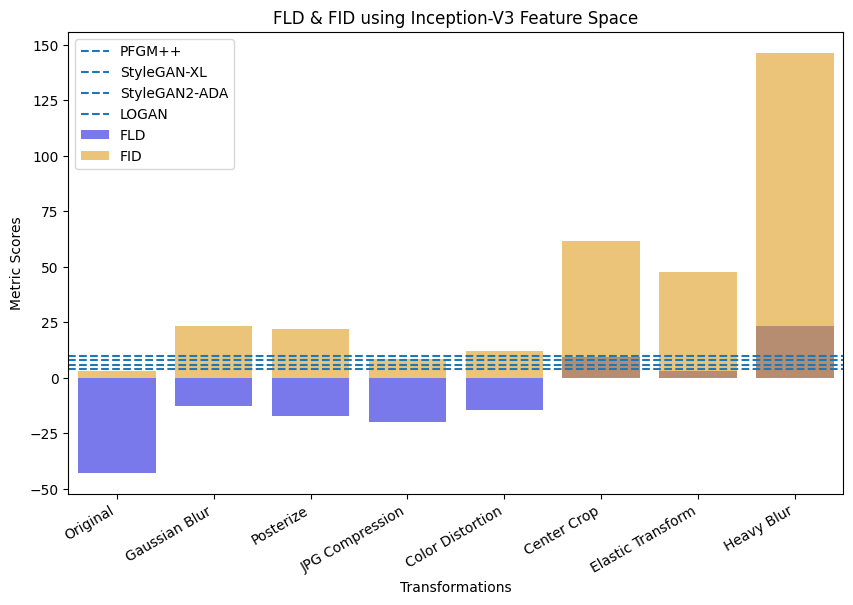

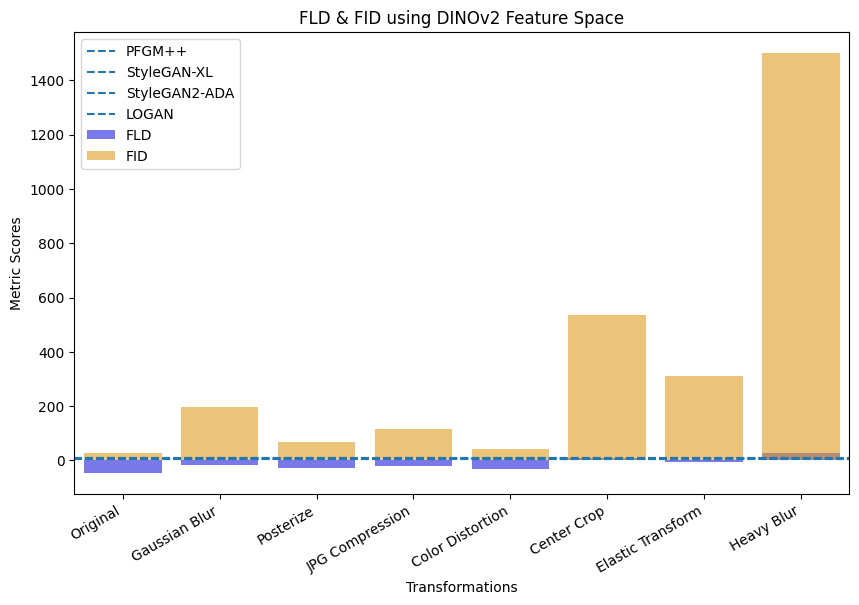

In [23]:
# Function to plot results
def plot_results(df_results, title, model_names=["PFGM++", "StyleGAN-XL", "StyleGAN2-ADA", "LOGAN"]):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df_results.index, y=df_results["FLD"], label="FLD", color="blue", alpha=0.6)
    sns.barplot(x=df_results.index, y=df_results["FID"], label="FID", color="orange", alpha=0.6)

    # Add reference model baselines as dashed lines
    model_scores = {"PFGM++": 4, "StyleGAN-XL": 6, "StyleGAN2-ADA": 8, "LOGAN": 10}
    for model, score in model_scores.items():
        plt.axhline(y=score, linestyle="--", label=model)

    plt.xticks(rotation=30, ha="right")
    plt.xlabel("Transformations")
    plt.ylabel("Metric Scores")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot results for Inception-V3 & DINOv2
plot_results(df_results_I, "FLD & FID using Inception-V3 Feature Space")
plot_results(df_results_D, "FLD & FID using DINOv2 Feature Space")


In [ ]:
#step two diversity
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from fld.features.DINOv2FeatureExtractor import DINOv2FeatureExtractor
from fld.metrics.FLD import FLD

# ----------------------
# Step 1: Load CIFAR-10 Dataset
# ----------------------
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

# Feature extractor (DINOv2 for better feature representations)
feature_extractor = DINOv2FeatureExtractor()

# Extract features for train and test sets
train_feat = feature_extractor.get_features(train_dataset)
test_feat = feature_extractor.get_features(test_dataset)

# Initialize FLD metric
fld_metric = FLD()

# ----------------------
# Experiment 1: Vary Number of Classes in Generated Samples
# ----------------------
def generate_samples_with_varying_classes(dataset, num_classes=1, num_samples=1000):
    """Generates a subset of CIFAR-10 with a limited number of classes."""
    class_indices = [i for i in range(10)]  # CIFAR-10 has 10 classes
    selected_classes = random.sample(class_indices, num_classes)  # Select num_classes
    
    filtered_indices = [i for i, label in enumerate(dataset.targets) if label in selected_classes]
    sampled_indices = random.sample(filtered_indices, min(num_samples, len(filtered_indices)))
    
    sampled_data = torch.stack([dataset.data[i] for i in sampled_indices]) / 255.0  # Normalize
    return sampled_data

num_classes_list = list(range(1, 10))  # From 1 to 9 classes
fld_results_classes = []

for num_classes in num_classes_list:
    gen_samples = generate_samples_with_varying_classes(train_dataset, num_classes)
    gen_feat = feature_extractor.get_tensor_features(gen_samples)  # Extract features
    fld_score = fld_metric.compute_metric(train_feat, test_feat, gen_feat)
    fld_results_classes.append(fld_score)

# Plot FLD vs. Number of Classes
plt.figure(figsize=(6, 4))
plt.plot(num_classes_list, fld_results_classes, marker='o', linestyle='-')
plt.xlabel("Number of Classes")
plt.ylabel("FLD Score")
plt.title("FLD vs. Number of Classes in Generated Samples")
plt.grid()
plt.show()

# ----------------------
# Experiment 2: Add Duplicates to the Generated Samples
# ----------------------
def generate_samples_with_duplicates(dataset, num_samples=1000, k=2):
    """Generate a dataset with duplicates (k-1 approximate copies per unique sample)."""
    unique_samples = random.sample(list(dataset.data), num_samples // k)
    
    # Generate duplicates
    duplicated_samples = []
    for img in unique_samples:
        for _ in range(k):  # Add (k-1) copies
            noisy_img = img + np.random.normal(0, 0.01, img.shape)  # Add minor noise to make it slightly different
            duplicated_samples.append(np.clip(noisy_img, 0, 255))  # Ensure valid pixel range

    duplicated_samples = torch.tensor(duplicated_samples) / 255.0  # Normalize
    return duplicated_samples

k_values = list(range(1, 11))  # From k=1 to k=10
fld_results_duplicates = []

for k in k_values:
    gen_samples = generate_samples_with_duplicates(train_dataset, num_samples=1000, k=k)
    gen_feat = feature_extractor.get_tensor_features(gen_samples)
    fld_score = fld_metric.compute_metric(train_feat, test_feat, gen_feat)
    fld_results_duplicates.append(fld_score)

# Plot FLD vs. Number of Duplicates
plt.figure(figsize=(6, 4))
plt.plot(k_values, fld_results_duplicates, marker='s', linestyle='-', color='red')
plt.xlabel("Duplicates per Sample (k)")
plt.ylabel("FLD Score")
plt.title("FLD vs. Increasing Duplicates in Generated Samples")
plt.grid()
plt.show()


In [21]:
# ----------------------
# Step 2: Define Generative Models (PFGM++, StyleGAN-XL, StyleGAN2-ADA, LOGAN)
# ----------------------
class RandomGAN(nn.Module):
    def __init__(self):
        super(RandomGAN, self).__init__()

    def forward(self, x):
        return torch.randn((128, 3, 32, 32)).clip(0, 1)



PFGMpp = RandomGAN()
StyleGAN_XL = RandomGAN()
StyleGAN2_ADA = RandomGAN()
LOGAN = RandomGAN()



# Function to generate images
def generate_imgs(model):
    return model(torch.randn((128, 100)))

In [22]:
# ----------------------
# Step 3: Define Transformations
# ----------------------
def jpg_compression(img):
    img_pil = transforms.ToPILImage()(img).convert("RGB")
    img_pil.save("temp.jpg", "JPEG", quality=90)
    return transforms.ToTensor()(Image.open("temp.jpg").convert("RGB"))

def pil_to_tensor_transform(pil_transform):
    return transforms.Compose([
        transforms.Lambda(lambda img: transforms.ToPILImage()(img).convert("RGB")),  
        pil_transform, 
        transforms.ToTensor()
    ])

minor_transforms = {
    "Gaussian Blur": transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    "Posterize": pil_to_tensor_transform(transforms.Lambda(lambda x: transforms.functional.posterize(x, bits=4))),
    "JPG Compression": transforms.Lambda(lambda x: jpg_compression(x)),
}

major_transforms = {
    "Color Distort": transforms.ColorJitter(brightness=0.5, contrast=0.5),
    "Center Crop": transforms.CenterCrop(size=(24, 24)),
    "Elastic Transform": transforms.ElasticTransform(alpha=(50.0, 50.0)),
    "Heavy Blur": transforms.GaussianBlur(kernel_size=7, sigma=(5.0, 10.0)),
}

In [ ]:
# ----------------------
# Step 4: Feature Extraction (Using DINOv2)
# ----------------------
feature_extractor = DINOv2FeatureExtractor()

train_feat = feature_extractor.get_dataset_features(train_dataset)
test_feat = feature_extractor.get_dataset_features(test_dataset)

# Extract features for models
models = {"PFGM++": PFGMpp, "StyleGAN-XL": StyleGAN_XL, "StyleGAN2-ADA": StyleGAN2_ADA, "LOGAN": LOGAN}
gen_feats = {name: feature_extractor.get_model_features(lambda: generate_imgs(model), num_samples=1000) for name, model in models.items()}

# Apply transformations to images
train_images = torch.stack([transforms.ToTensor()(train_dataset[i][0]) for i in range(1000)])

minor_transformed_images = {name: torch.stack([t(img) for img in train_images]) for name, t in minor_transforms.items()}
major_transformed_images = {name: torch.stack([t(img) for img in train_images]) for name, t in major_transforms.items()}

# Extract features from transformed images
minor_transformed_feats = {name: feature_extractor.get_tensor_features(imgs) for name, imgs in minor_transformed_images.items()}
major_transformed_feats = {name: feature_extractor.get_tensor_features(imgs) for name, imgs in major_transformed_images.items()}


In [ ]:
# ----------------------
# Step 5: Compute FLD and FID
# ----------------------
fld_metric = FLD()
fid_metric = FID()

fld_results = {model: fld_metric.compute_metric(train_feat, test_feat, feat) for model, feat in gen_feats.items()}
fid_results = {model: fid_metric.compute_metric(train_feat, None, feat) for model, feat in gen_feats.items()}

minor_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in minor_transformed_feats.items()}
minor_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in minor_transformed_feats.items()}

major_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in major_transformed_feats.items()}
major_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in major_transformed_feats.items()}


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main
  0%|                                                                                                                                         | 0/8 [00:00<?, ?it/s]
%|                                                                                                                                         | 0/1 [00:00<?, ?it/s]
%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.25s/it]
 12%|████████████████▏                                                                                                                | 1/8 [00:06<00:48,  6.86s/it]
%|                                                                                                                                         | 0/1 [00:00<?, ?it/s]
%|████████████████████████████████████████████████████████████████████████████████████████████████████

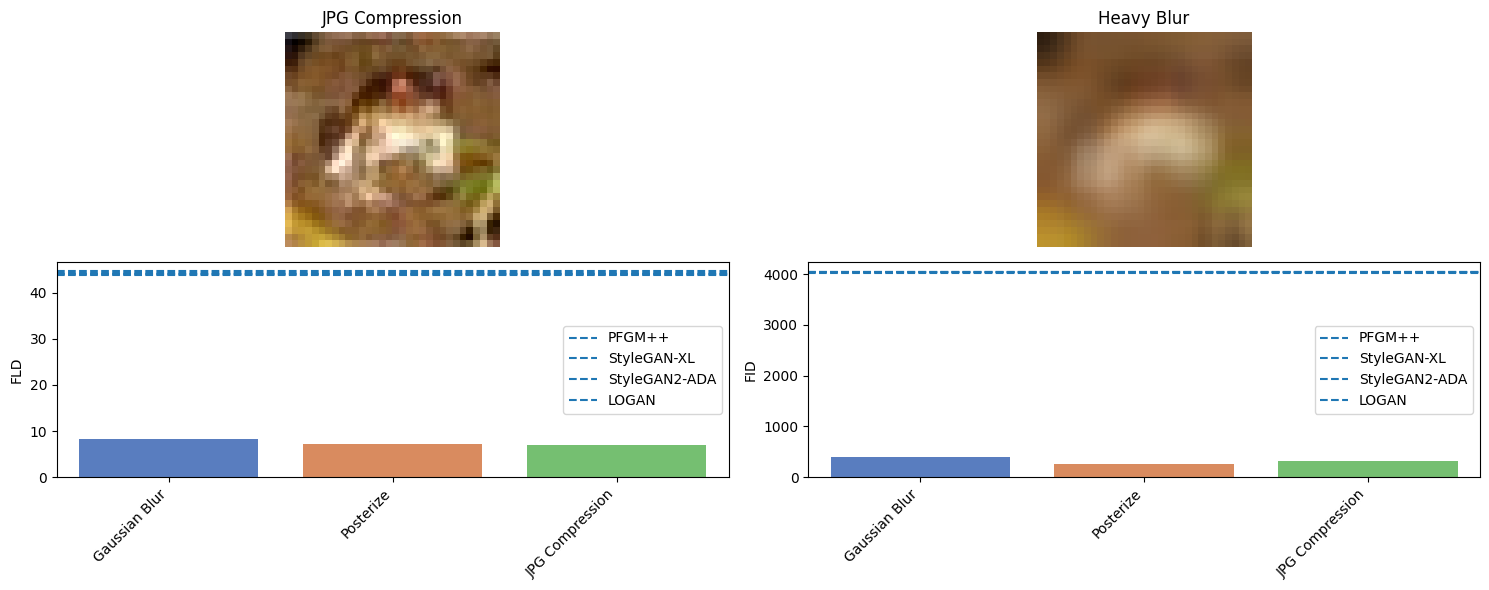

In [22]:
# ----------------------
# Step 5: Compute FLD and FID
# ----------------------
fld_metric = FLD()
fid_metric = FID()

fld_results = {model: fld_metric.compute_metric(train_feat, test_feat, feat) for model, feat in gen_feats.items()}
fid_results = {model: fid_metric.compute_metric(train_feat, None, feat) for model, feat in gen_feats.items()}

minor_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in minor_transformed_feats.items()}
minor_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in minor_transformed_feats.items()}

major_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in major_transformed_feats.items()}
major_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in major_transformed_feats.items()}

# ----------------------
# Step 6: Plot Results
# ----------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Convert tensor to PIL image function
def tensor_to_pil(img_tensor):
    return transforms.ToPILImage()(img_tensor.cpu())

# Display original and transformed images
for i, (name, imgs) in enumerate(minor_transformed_images.items()):
    axes[0, 0].imshow(tensor_to_pil(imgs[0]))
    axes[0, 0].set_title(name)
    axes[0, 0].axis("off")

for i, (name, imgs) in enumerate(major_transformed_images.items()):
    axes[0, 1].imshow(tensor_to_pil(imgs[0]))
    axes[0, 1].set_title(name)
    axes[0, 1].axis("off")

# Plot FLD and FID for minor transformations
labels = list(minor_fld_results.keys())
fld_values = list(minor_fld_results.values())
fid_values = list(minor_fid_results.values())

sns.barplot(x=labels, y=fld_values, ax=axes[1, 0], palette="muted")
axes[1, 0].set_ylabel("FLD")
axes[1, 0].set_xticklabels(labels, rotation=45, ha="right")

sns.barplot(x=labels, y=fid_values, ax=axes[1, 1], palette="muted")
axes[1, 1].set_ylabel("FID")
axes[1, 1].set_xticklabels(labels, rotation=45, ha="right")

# -------------------
# Step 7: Dashed Line Reference Models
# -------------------
for model, fld in fld_results.items():
    axes[1, 0].axhline(y=fld, linestyle="--", label=model)
for model, fid in fid_results.items():
    axes[1, 1].axhline(y=fid, linestyle="--", label=model)

axes[1, 0].legend()
axes[1, 1].legend()

plt.tight_layout()
plt.show()


In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.features.DINOv2FeatureExtractor import DINOv2FeatureExtractor  # Use DINOv2 as in the paper
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [16]:
# ----------------------
# Step 1: Load Data
# ----------------------
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.ToTensor())
train_dataset.name = "CIFAR10_train"

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transforms.ToTensor())
test_dataset.name = "CIFAR10_test"

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Extract a batch of training images for transformations
train_images = next(iter(train_loader))[0]


Files already downloaded and verified
Files already downloaded and verified


In [18]:
class RandomGAN(nn.Module):
    def __init__(self):
        super(RandomGAN, self).__init__()

    def forward(self, x):
        return torch.randn((128, 3, 32, 32)).clip(0, 1)


GAN = RandomGAN()
# Use Pre-trained Models or Simulated Generators
PFGM = RandomGAN()  # Placeholder, replace with actual PFGM++ implementation
StyleGAN_XL = RandomGAN()  # Placeholder, replace with actual StyleGAN-XL
StyleGAN2_ADA = RandomGAN()  # Placeholder, replace with actual StyleGAN2-ADA
LOGAN = RandomGAN()  # Placeholder, replace with actual LOGAN model

generative_models = {
    "PFGM++": PFGM,
    "StyleGAN-XL": StyleGAN_XL,
    "StyleGAN2-ADA": StyleGAN2_ADA,
    "LOGAN": LOGAN,
}

# Function to generate images
def generate_imgs(model):
    return model(torch.randn((128, 100))).cuda()
    
# # Create a no-argument function that returns batches of images
# def generate_imgs(model):
#     x = torch.randn((128, 100))
#     return GAN(x).cuda()

In [19]:
# ----------------------
# Step 2: Define Transformations
# ----------------------

# Function to simulate JPG compression (returns tensor)
def jpg_compression(img):
    img_pil = transforms.ToPILImage()(img).convert("RGB")
    img_pil.save("temp.jpg", "JPEG", quality=90)
    return transforms.ToTensor()(Image.open("temp.jpg").convert("RGB"))

# Function to ensure all transformations return tensors
def pil_to_tensor_transform(pil_transform):
    return transforms.Compose([
        transforms.Lambda(lambda img: transforms.ToPILImage()(img).convert("RGB")),  
        pil_transform,  # Apply PIL-based transformation
        transforms.ToTensor()  # Convert back to tensor
    ])

minor_transforms = {
    "Gaussian Blur": transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    "Posterize": pil_to_tensor_transform(transforms.Lambda(lambda x: transforms.functional.posterize(x, bits=4))),
    "JPG Compression": transforms.Lambda(lambda x: jpg_compression(x)),
}

major_transforms = {
    "Cropping": transforms.CenterCrop(size=(24, 24)),
    "Rotation": transforms.RandomRotation(degrees=30),
    "Elastic Transform": transforms.ElasticTransform(alpha=(50.0, 50.0)),
}

In [20]:
# Apply transformations (Ensure all results are tensors)
minor_transformed_images = {name: torch.stack([t(img) for img in train_images.cpu()]) for name, t in minor_transforms.items()}
major_transformed_images = {name: torch.stack([t(img) for img in train_images.cpu()]) for name, t in major_transforms.items()}

In [21]:
# ----------------------
# Step 3: Feature Extraction
# ----------------------
feature_extractor_1 = InceptionFeatureExtractor()
feature_extractor_2 = DINOv2FeatureExtractor()

print("extracting for INCEPTION")
# Extract features for original images
train_feat_1 = feature_extractor_1.get_dataset_features(train_dataset)
test_feat_1 = feature_extractor_1.get_dataset_features(test_dataset)

print("extracting for DINOV2")
train_feat_2 = feature_extractor_2.get_dataset_features(train_dataset)
test_feat_2 = feature_extractor_2.get_dataset_features(test_dataset)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to C:\Users\oumni/.cache\torch\hub\main.zip
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to C:\Users\oumni/.cache\torch\hub\checkpoints\dinov2_vitb14_pretrain.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330

extracting for INCEPTION


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\oumni\PycharmProjects\ift6164\fld\env\Lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\oumni\PycharmProjects\ift6164\fld\env\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\oumni\PycharmProjects\ift6164\fld\env\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "C:\Users\oumni\PycharmProjects\ift6164\fld\fld\features\FeatureExtractor.py", line 22, in __getitem__
    img = self.transform(img)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\oumni\PycharmProjects\ift6164\fld\env\Lib\site-packages\torchvision\transforms\transforms.py", line 137, in __call__
    return F.to_tensor(pic)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\oumni\PycharmProjects\ift6164\fld\env\Lib\site-packages\torchvision\transforms\functional.py", line 142, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


In [5]:
# Convert images to tensors
# transform_to_tensor = transforms.Compose([transforms.ToTensor()])
# train_images = torch.stack([transform_to_tensor(train_dataset[i][0]) for i in range(1000)]).to(device)
# test_images = torch.stack([transform_to_tensor(test_dataset[i][0]) for i in range(1000)]).to(device)

In [9]:
assert train_feat is not None and len(train_feat) > 0, "Error: train_feat is empty!"
assert test_feat is not None and len(test_feat) > 0, "Error: test_feat is empty!"

In [10]:
# Extract features for transformed images
minor_transformed_feats = {name: feature_extractor.get_model_features(lambda: imgs, num_samples=1000) for name, imgs in minor_transformed_images.items()}
major_transformed_feats = {name: feature_extractor.get_model_features(lambda: imgs, num_samples=1000) for name, imgs in major_transformed_images.items()}


  0%|                                                                                                                                         | 0/1 [00:00<?, ?it/s]
%|                                                                                                                                         | 0/4 [00:00<?, ?it/s]
%|████████████████████████████████▎                                                                                                | 1/4 [00:04<00:13,  4.47s/it]
%|████████████████████████████████████████████████████████████████▌                                                                | 2/4 [00:05<00:04,  2.18s/it]
%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 3/4 [00:05<00:01,  1.45s/it]
%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.08s/it]
  0%|                    

In [11]:
# ----------------------
# Step 4: Compute FLD and FID
# ----------------------
fld_metric = FLD()
fid_metric = FID()

original_fld = fld_metric.compute_metric(train_feat, test_feat, train_feat)
original_fid = fid_metric.compute_metric(train_feat, None, train_feat)

minor_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in minor_transformed_feats.items()}
minor_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in minor_transformed_feats.items()}

major_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in major_transformed_feats.items()}
major_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in major_transformed_feats.items()}

In [12]:
# ----------------------
# Step 5: Display Results
# ----------------------
results = {
    "Original": {"FLD": original_fld, "FID": original_fid},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(minor_fld_results.keys(), minor_fld_results.values(), minor_fid_results.values())},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(major_fld_results.keys(), major_fld_results.values(), major_fid_results.values())},
}

# Convert results to DataFrame for better readability
df_results = pd.DataFrame(results).T
print(df_results)

                         FLD           FID
Original                 NaN  5.115510e-09
Gaussian Blur       6.235886  5.205835e+01
Posterize           8.386111  4.928600e+01
JPG Compression     4.111147  3.593014e+01
Cropping            3.795338  4.328765e+01
Rotation           14.316618  1.352327e+02
Elastic Transform   9.306264  7.650054e+01


C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\3604606021.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=fld_values, ax=axes[1, 0], palette="muted")
C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\3604606021.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(labels, rotation=45, ha="right")
C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\3604606021.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=fid_values, ax=axes[1, 1], palette="muted")
C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\3604606021.py:57: UserWarning: set_ticklabels() sh

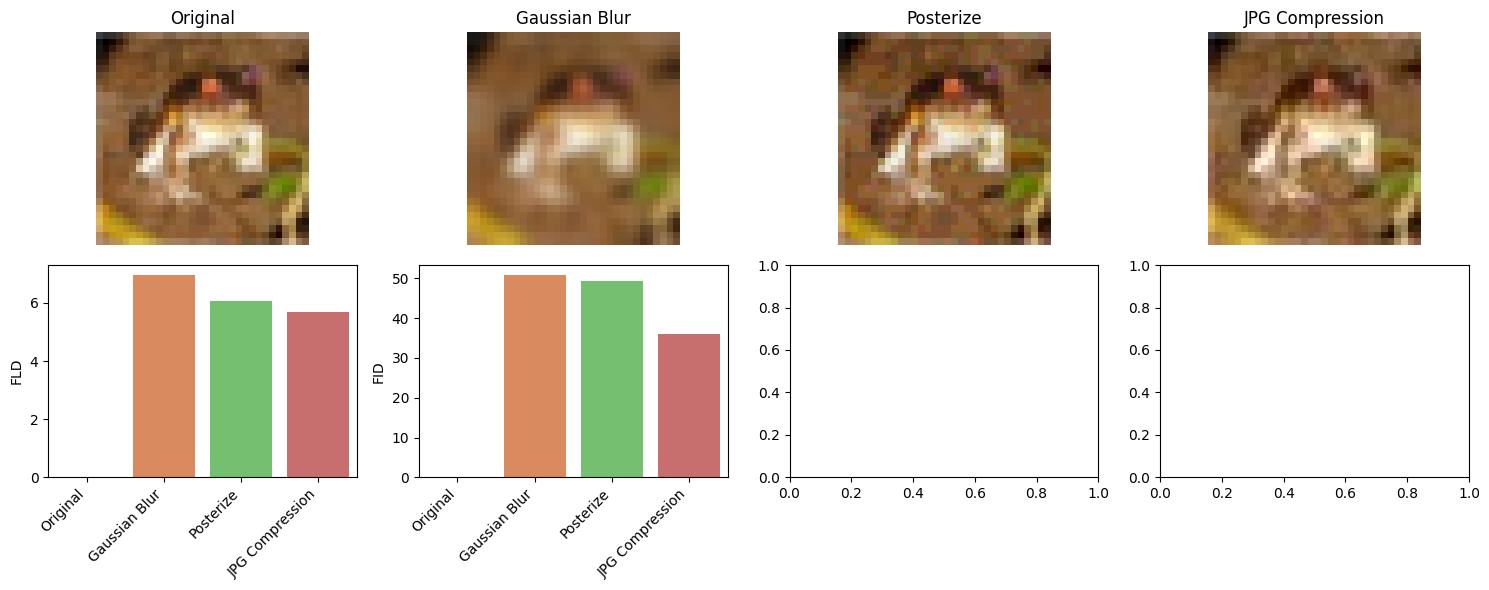

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torchvision.transforms as transforms
from PIL import Image

# ----------------------
# Step 6: Display Transformed Images & Results
# ----------------------
fig, axes = plt.subplots(2, len(minor_transforms) + 1, figsize=(15, 6))

# Convert tensor to PIL image function
def tensor_to_pil(img_tensor):
    """Ensure img_tensor is a tensor before converting to PIL image"""
    if isinstance(img_tensor, Image.Image):  # If already PIL, return as is
        return img_tensor
    if img_tensor.ndimension() == 4:  # Convert batch of images
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.cpu().detach()  # Move to CPU and detach
    return transforms.ToPILImage()(img_tensor)

# Ensure the original image is converted properly
original_image = train_dataset[0][0]  # This is a PIL image
original_image_tensor = transforms.ToTensor()(original_image)  # Convert PIL to tensor

# -------------------
# Top Row: Transformed Images
# -------------------
axes[0, 0].imshow(tensor_to_pil(original_image_tensor))
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")

# Minor Transformations
for i, (name, imgs) in enumerate(minor_transformed_images.items()):
    axes[0, i + 1].imshow(tensor_to_pil(imgs[0]))
    axes[0, i + 1].set_title(name)
    axes[0, i + 1].axis("off")

# -------------------
# Bottom Row: Bar Chart for FLD & FID
# -------------------
# Prepare FLD and FID values
fld_values = [original_fld] + list(minor_fld_results.values())
fid_values = [original_fid] + list(minor_fid_results.values())

# X-axis Labels
labels = ["Original"] + list(minor_fld_results.keys())

# Plot FLD
sns.barplot(x=labels, y=fld_values, ax=axes[1, 0], palette="muted")
axes[1, 0].set_ylabel("FLD")
axes[1, 0].set_xticklabels(labels, rotation=45, ha="right")

# Plot FID
sns.barplot(x=labels, y=fid_values, ax=axes[1, 1], palette="muted")
axes[1, 1].set_ylabel("FID")
axes[1, 1].set_xticklabels(labels, rotation=45, ha="right")

# Adjust Layout
plt.tight_layout()
plt.show()


C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\4101961713.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=fld_values, ax=axes[1, 0], palette="muted")
C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\4101961713.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(labels, rotation=45, ha="right")
C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\4101961713.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=fid_values, ax=axes[1, 1], palette="muted")
C:\Users\oumni\AppData\Local\Temp\ipykernel_24280\4101961713.py:64: UserWarning: set_ticklabels() sh

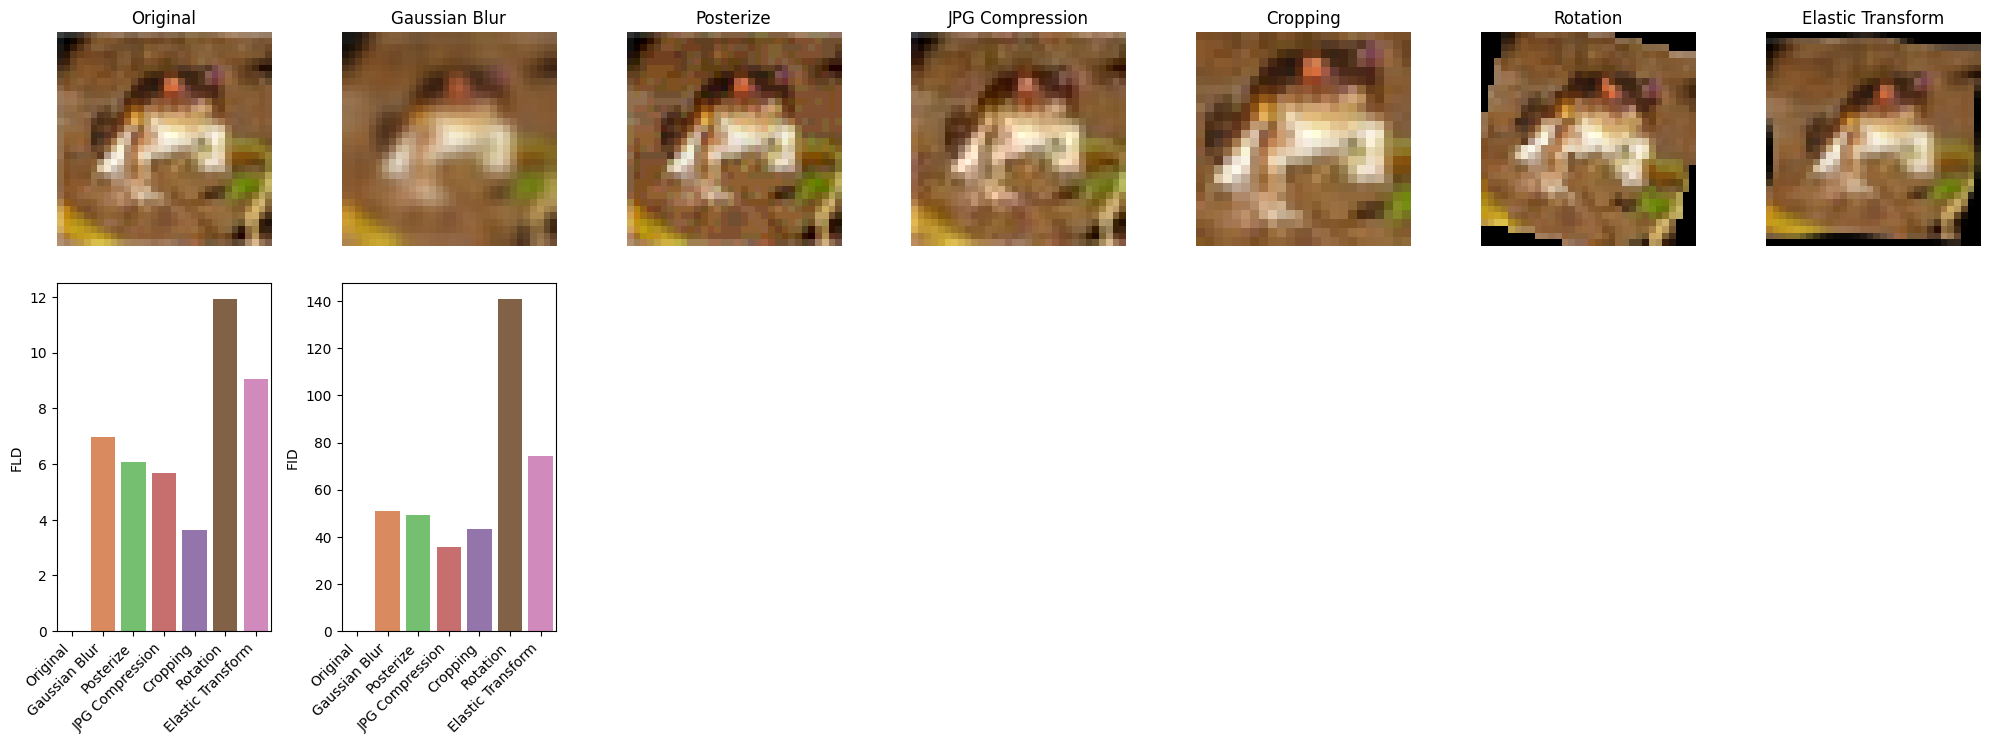

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torchvision.transforms as transforms
from PIL import Image

# ----------------------
# Step 6: Display Transformed Images & Results
# ----------------------
num_cols = len(minor_transforms) + len(major_transforms) + 1  # Original + all transformations
fig, axes = plt.subplots(2, num_cols, figsize=(20, 8))  # Wider to fit all transformations

# Convert tensor to PIL image function
def tensor_to_pil(img_tensor):
    """Ensure img_tensor is a tensor before converting to PIL image"""
    if isinstance(img_tensor, Image.Image):  # If already PIL, return as is
        return img_tensor
    if img_tensor.ndimension() == 4:  # Convert batch of images
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.cpu().detach()  # Move to CPU and detach
    return transforms.ToPILImage()(img_tensor)

# Ensure the original image is converted properly
original_image = train_dataset[0][0]  # PIL image
original_image_tensor = transforms.ToTensor()(original_image)  # Convert PIL to tensor

# -------------------
# Top Row: Transformed Images
# -------------------
axes[0, 0].imshow(tensor_to_pil(original_image_tensor))
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")

# Minor Transformations
for i, (name, imgs) in enumerate(minor_transformed_images.items()):
    axes[0, i + 1].imshow(tensor_to_pil(imgs[0]))
    axes[0, i + 1].set_title(name)
    axes[0, i + 1].axis("off")

# Major Transformations
for i, (name, imgs) in enumerate(major_transformed_images.items(), len(minor_transforms) + 1):
    axes[0, i].imshow(tensor_to_pil(imgs[0]))
    axes[0, i].set_title(name)
    axes[0, i].axis("off")

# -------------------
# Bottom Row: Bar Chart for FLD & FID
# -------------------
# Prepare FLD and FID values
fld_values = [original_fld] + list(minor_fld_results.values()) + list(major_fld_results.values())
fid_values = [original_fid] + list(minor_fid_results.values()) + list(major_fid_results.values())

# X-axis Labels
labels = ["Original"] + list(minor_fld_results.keys()) + list(major_fld_results.keys())

# Plot FLD
sns.barplot(x=labels, y=fld_values, ax=axes[1, 0], palette="muted")
axes[1, 0].set_ylabel("FLD")
axes[1, 0].set_xticklabels(labels, rotation=45, ha="right")

# Plot FID
sns.barplot(x=labels, y=fid_values, ax=axes[1, 1], palette="muted")
axes[1, 1].set_ylabel("FID")
axes[1, 1].set_xticklabels(labels, rotation=45, ha="right")

# Ensure remaining subplots are removed to match layout
for i in range(2, num_cols):
    fig.delaxes(axes[1, i])  # Remove empty plots

# Adjust Layout
plt.tight_layout()
plt.show()


                         FLD           FID
Original                 NaN  4.187882e-09
Gaussian Blur       5.965722  5.079638e+01
Posterize           5.916953  4.928597e+01
JPG Compression     5.434632  3.593020e+01
Cropping            2.936172  4.328767e+01
Rotation           10.863125  1.406880e+02
Elastic Transform   6.990361  7.438550e+01


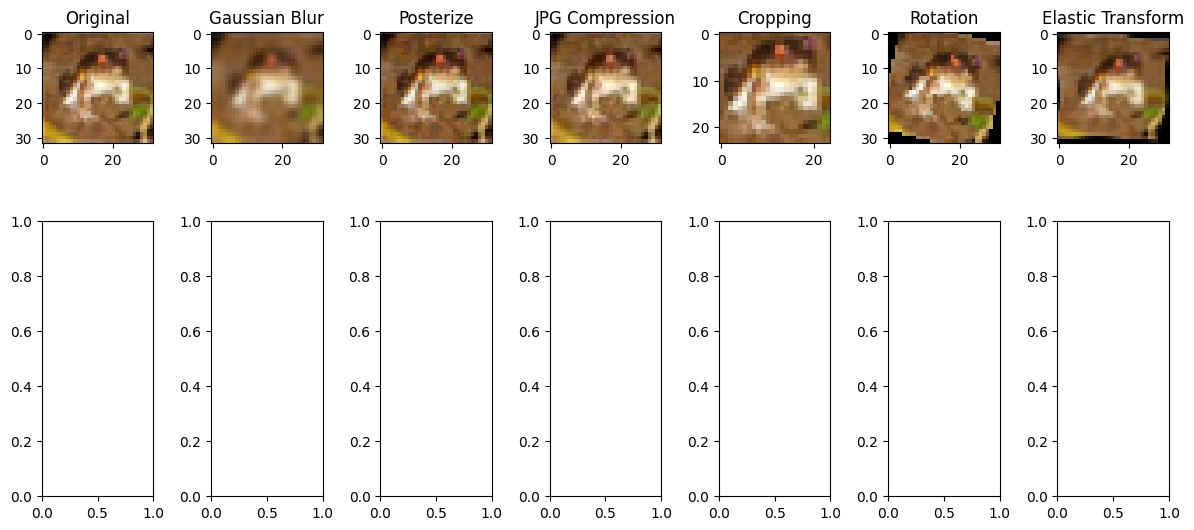

In [18]:
# ----------------------
# Step 6: Display Transformed Images
# ----------------------
fig, axes = plt.subplots(2, len(minor_transforms) + len(major_transforms) + 1, figsize=(12, 6))
axes = axes.flatten()

# Convert tensor to PIL image function
def tensor_to_pil(img_tensor):
    """Ensure img_tensor is a tensor before converting to PIL image"""
    if isinstance(img_tensor, Image.Image):  # If already PIL, return as is
        return img_tensor
    return transforms.ToPILImage()(img_tensor.cpu())

# Ensure the original image is converted properly
original_image = train_dataset[0][0]  # This is a PIL image
original_image_tensor = transforms.ToTensor()(original_image)  # Convert PIL to tensor

# Original Image
axes[0].imshow(tensor_to_pil(original_image_tensor))
axes[0].set_title("Original")

# Minor Transformations
for i, (name, imgs) in enumerate(minor_transformed_images.items(), 1):
    axes[i].imshow(tensor_to_pil(imgs[0]))
    axes[i].set_title(name)

# Major Transformations
for i, (name, imgs) in enumerate(major_transformed_images.items(), len(minor_transforms) + 1):
    axes[i].imshow(tensor_to_pil(imgs[0]))
    axes[i].set_title(name)

plt.tight_layout()
plt.show()


In [14]:
from fld.features.InceptionFeatureExtractor import (
    InceptionFeatureExtractor,
)  # or DINOv2FeatureExtractor/CLIPFeatureExtractor

feature_extractor = InceptionFeatureExtractor()

# FLD needs 3 sets of samples: train, test and gen
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
train_dataset.name = "CIFAR10_train"  # Dataset needs a name to cache features

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
test_dataset.name = "CIFAR10_test"


Files already downloaded and verified
Files already downloaded and verified


                         FLD           FID
Original                 NaN  3.998593e-09
Gaussian Blur       7.347941  5.079628e+01
Posterize           6.666553  4.928600e+01
JPG Compression     5.310392  3.593017e+01
Cropping            3.671372  4.328768e+01
Rotation           10.900509  1.406880e+02
Elastic Transform   8.327496  7.438547e+01


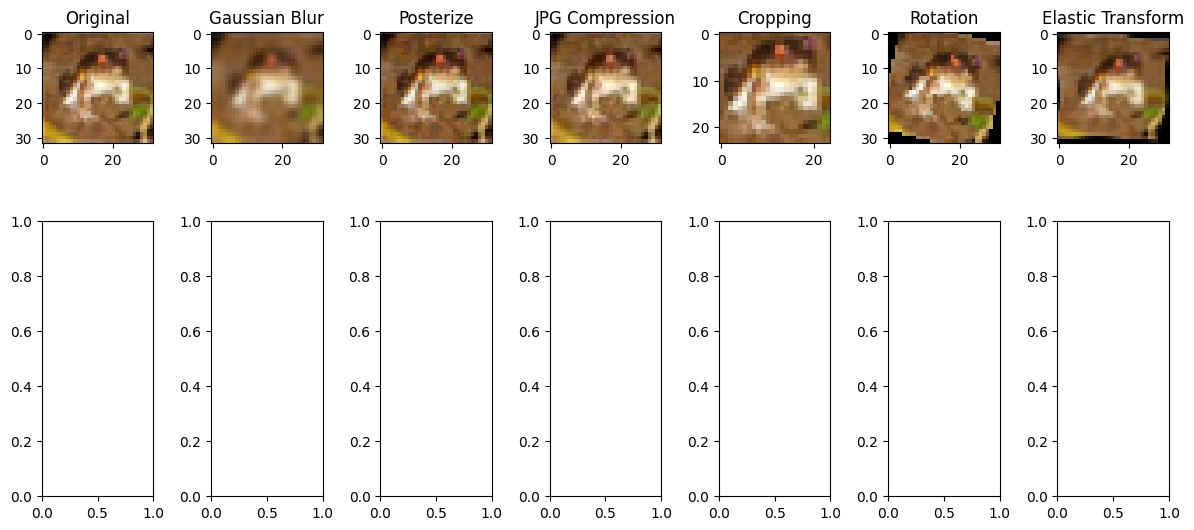

In [24]:
# ----------------------
# Step 5: Display Results
# ----------------------
results = {
    "Original": {"FLD": original_fld, "FID": original_fid},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(minor_fld_results.keys(), minor_fld_results.values(), minor_fid_results.values())},
    **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(major_fld_results.keys(), major_fld_results.values(), major_fid_results.values())},
}

# Convert results to DataFrame for better readability
df_results = pd.DataFrame(results).T
print(df_results)

# ----------------------
# Step 6: Display Transformed Images
# ----------------------
fig, axes = plt.subplots(2, len(minor_transforms) + len(major_transforms) + 1, figsize=(12, 6))
axes = axes.flatten()

# Convert tensor to PIL image function
def tensor_to_pil(img_tensor):
    """Ensure img_tensor is a tensor before converting to PIL image"""
    if isinstance(img_tensor, Image.Image):  # If already PIL, return as is
        return img_tensor
    return transforms.ToPILImage()(img_tensor.cpu())

# Ensure the original image is converted properly
original_image = train_dataset[0][0]  # This is a PIL image
original_image_tensor = transforms.ToTensor()(original_image)  # Convert PIL to tensor

# Original Image
axes[0].imshow(tensor_to_pil(original_image_tensor))
axes[0].set_title("Original")

# Minor Transformations
for i, (name, imgs) in enumerate(minor_transformed_images.items(), 1):
    axes[i].imshow(tensor_to_pil(imgs[0]))
    axes[i].set_title(name)

# Major Transformations
for i, (name, imgs) in enumerate(major_transformed_images.items(), len(minor_transforms) + 1):
    axes[i].imshow(tensor_to_pil(imgs[0]))
    axes[i].set_title(name)

plt.tight_layout()
plt.show()


In [7]:
#load all datasets
# ----------------------
# Step 2: Load Datasets
# ----------------------
datasets = {}

for dataset_name in ["CIFAR10", "FFHQ", "ImageNet"]:
    if dataset_name == "CIFAR10":
        transform = transforms.Compose([transforms.ToTensor()])
        train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "ImageNet":
        transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
        train_dataset = torchvision.datasets.ImageNet(root="./data/ImageNet/train", train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.ImageNet(root="./data/ImageNet/test",  train=False, download=True, transform=transform)
        # elif dataset_name == "FFHQ":
        # # Assuming FFHQ dataset is preprocessed and available in a folder
        # transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
        # #train_dataset = torchvision.datasets.ImageFolder(root="./data/FFHQ/train", transform=transform)
        # #test_dataset = torchvision.datasets.ImageFolder(root="./data/FFHQ/test", transform=transform)
        # train_dataset = torchvision.datasets.CIFAR10(root="./data/FFHQ", train=True, download=True, transform=transform)
        # test_dataset = torchvision.datasets.CIFAR10(root="./data/FFHQ", train=False, download=True, transform=transform)
    datasets[dataset_name] = {
        "train": train_dataset,
        "test": test_dataset,
    }

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in ./data/ImageNet/train.

In [3]:



class RandomGAN(nn.Module):
    def __init__(self):
        super(RandomGAN, self).__init__()

    def forward(self, x):
        return torch.randn((128, 3, 32, 32)).clip(0, 1)


GAN = RandomGAN()


# Create a no-argument function that returns batches of images
def generate_imgs():
    x = torch.randn((128, 100))
    return GAN(x).cuda()

### Mapping images to features
To work in a more perceptually space, we must first map samples to meaningful features.

In [5]:
from fld.features.InceptionFeatureExtractor import (
    InceptionFeatureExtractor,
)  # or DINOv2FeatureExtractor/CLIPFeatureExtractor

feature_extractor = InceptionFeatureExtractor()

# FLD needs 3 sets of samples: train, test and gen
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
train_dataset.name = "CIFAR10_train"  # Dataset needs a name to cache features

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)
test_dataset.name = "CIFAR10_test"


Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


FileNotFoundError: [WinError 3] The system cannot find the path specified: './data/FFHQ/train'

In [12]:
len(train_dataset)

50000

In [13]:
len(test_dataset)

10000

In [14]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
# get_dataset_features to compute features of a torch.utils.Dataset
train_feat = feature_extractor.get_dataset_features(train_dataset)
test_feat = feature_extractor.get_dataset_features(test_dataset)

In [7]:
# Can get features directly from a model (e.g. RandomGAN) with get_model_features
gen_feat = feature_extractor.get_model_features(generate_imgs, num_samples=10_000)


  0%|                                                                                                                                                           | 0/79 [00:00<?, ?it/s]
%|                                                                                                                                                            | 0/1 [00:00<?, ?it/s]
%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]
  1%|█▊                                                                                                                                                 | 1/79 [00:03<04:51,  3.74s/it]
%|                                                                                                                                                            | 0/1 [00:00<?, ?it/s]
%|███████████████████████████████████████████████████████████████████████████████████████

In [8]:
gen_feat

tensor([[0.4822, 0.0000, 0.0142,  ..., 0.1552, 0.0132, 0.1458],
        [0.5343, 0.0026, 0.0128,  ..., 0.1804, 0.0232, 0.3326],
        [0.6345, 0.0000, 0.0000,  ..., 0.3343, 0.0188, 0.3348],
        ...,
        [0.6952, 0.0000, 0.0276,  ..., 0.4552, 0.0111, 0.5895],
        [0.7162, 0.0000, 0.0704,  ..., 0.2327, 0.0349, 0.4391],
        [0.5603, 0.0000, 0.0907,  ..., 0.2210, 0.0000, 0.4824]])

## Computing metrics
Once the three sets of features are ready, metrics can be computed!

In [9]:
# And many others!
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID

# Compute FLD, FID 
cifar_fld = FLD().compute_metric(train_feat, test_feat, gen_feat)
cifar_fid = FID().compute_metric(train_feat, None, gen_feat)

print(f"Random GAN FLD: {cifar_fld:.2f}")
print(f"Random GAN FID: {cifar_fid:.2f}")

# Make sure RandomGAN isn't overfitting (more negative is more overfit)
gen_gap = FLD("gap").compute_metric(train_feat, test_feat, gen_feat)
print(f"Random GAN FLD Generalization Gap: {gen_gap:.2f}")

Random GAN FLD: 55.51
Random GAN FID: 440.51


Random GAN FLD Generalization Gap: 0.04


### CopycatModel for copying training samples and evaluate fld vs fid

Using device: cuda


Files already downloaded and verified
Files already downloaded and verified
Extracting features for datasets...


Extracting features for RandomGAN...


  0%|                                                                                                                                                           | 0/79 [00:00<?, ?it/s]
%|                                                                                                                                                            | 0/1 [00:00<?, ?it/s]
%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]
  1%|█▊                                                                                                                                                 | 1/79 [00:03<05:08,  3.95s/it]
%|                                                                                                                                                            | 0/1 [00:00<?, ?it/s]
%|███████████████████████████████████████████████████████████████████████████████████████

Extracting features for Copycat model...


  0%|                                                                                                                                                           | 0/79 [00:00<?, ?it/s]
%|                                                                                                                                                            | 0/1 [00:00<?, ?it/s]
%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]
  1%|█▊                                                                                                                                                 | 1/79 [00:04<05:18,  4.08s/it]
%|                                                                                                                                                            | 0/1 [00:00<?, ?it/s]
%|███████████████████████████████████████████████████████████████████████████████████████

In [5]:
torch.cuda.empty_cache()


C:\Users\oumni\PycharmProjects\ift6164\fld\fld\metrics\FLD.py:78: UserWarning: Very high FLD value, your generated data is likely completely memorized.                                
  warnings.warn(
                                                                                                                                                                                       


--- Evaluation Results ---
RandomGAN Metrics:
  FLD: 55.80
  FID (Train): 440.37
  FID (Test): 440.65
  Generalization Gap: 0.06

Copycat Metrics:
  FLD: 811501.04
  FID (Train): 2.12
  FID (Test): 5.20
  Generalization Gap: -163051.76


C:\Users\oumni\PycharmProjects\ift6164\fld\fld\metrics\FLD.py:59: UserWarning: Very high FLD gen gap value: your generated data is likely completely memorized.
  warnings.warn(


In [ ]:

# ----------------------
# Step 10: Insights
# ----------------------
print("\n--- Insights ---")
print("Observe how the Copycat model achieves perfect FID when compared to the training set,")
print("but fails to generalize (worse FID when compared to the test set) and has a higher generalization gap.")


In [2]:
# # ----------------------
# # Step 1: Load CIFAR-10 Dataset
# # ----------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_dataset = datasets.CIFAR10(root="./data", train=True, download=True)
# test_dataset = datasets.CIFAR10(root="./data", train=False, download=True)

# # Convert images to tensors
# transform_to_tensor = transforms.Compose([transforms.ToTensor()])
# train_images = torch.stack([transform_to_tensor(train_dataset[i][0]) for i in range(1000)]).to(device)
# test_images = torch.stack([transform_to_tensor(test_dataset[i][0]) for i in range(1000)]).to(device)

# # ----------------------
# # Step 2: Define Transformations
# # ----------------------
# minor_transforms = {
#     "Gaussian Blur": transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
#     "Posterize": transforms.Lambda(lambda x: transforms.functional.posterize(x, bits=4)),
#     "JPG Compression": transforms.Lambda(lambda x: transforms.ToTensor()(transforms.functional.to_pil_image(x).convert("RGB").save("temp.jpg", "JPEG", quality=90)) or transforms.ToTensor()(Image.open("temp.jpg"))),
# }

# major_transforms = {
#     "Cropping": transforms.CenterCrop(size=(24, 24)),
#     "Rotation": transforms.RandomRotation(degrees=30),
#     "Elastic Transform": transforms.ElasticTransform(alpha=50),
# }

# # Apply transformations
# minor_transformed_images = {name: torch.stack([t(img) for img in train_images]) for name, t in minor_transforms.items()}
# major_transformed_images = {name: torch.stack([t(img) for img in train_images]) for name, t in major_transforms.items()}

# # ----------------------
# # Step 3: Feature Extraction
# # ----------------------
# feature_extractor = InceptionFeatureExtractor()

# # Extract features for original images
# train_feat = feature_extractor.get_dataset_features(train_dataset)
# test_feat = feature_extractor.get_dataset_features(test_dataset)

# # Extract features for transformed images
# minor_transformed_feats = {name: feature_extractor.get_model_features(lambda: imgs, num_samples=1000) for name, imgs in minor_transformed_images.items()}
# major_transformed_feats = {name: feature_extractor.get_model_features(lambda: imgs, num_samples=1000) for name, imgs in major_transformed_images.items()}

# # ----------------------
# # Step 4: Compute FLD and FID
# # ----------------------
# fld_metric = FLD()
# fid_metric = FID()

# original_fld = fld_metric.compute_metric(train_feat, test_feat, train_feat)
# original_fid = fid_metric.compute_metric(train_feat, None, train_feat)

# minor_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in minor_transformed_feats.items()}
# minor_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in minor_transformed_feats.items()}

# major_fld_results = {name: fld_metric.compute_metric(train_feat, test_feat, feat) for name, feat in major_transformed_feats.items()}
# major_fid_results = {name: fid_metric.compute_metric(train_feat, None, feat) for name, feat in major_transformed_feats.items()}

# # ----------------------
# # Step 5: Display Results
# # ----------------------
# results = {
#     "Original": {"FLD": original_fld, "FID": original_fid},
#     **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(minor_fld_results.keys(), minor_fld_results.values(), minor_fid_results.values())},
#     **{name: {"FLD": fld, "FID": fid} for name, fld, fid in zip(major_fld_results.keys(), major_fld_results.values(), major_fid_results.values())},
# }

# # Convert results to DataFrame for better readability
# import pandas as pd
# df_results = pd.DataFrame(results).T
# print(df_results)


# # Display transformed images for reference
# fig, axes = plt.subplots(2, len(minor_transforms) + len(major_transforms) + 1, figsize=(12, 6))
# axes = axes.flatten()

# # Original Image
# axes[0].imshow(train_dataset[0][0])
# axes[0].set_title("Original")

# # Minor Transformations
# for i, (name, imgs) in enumerate(minor_transformed_images.items(), 1):
#     axes[i].imshow(imgs[0].cpu().permute(1, 2, 0))
#     axes[i].set_title(name)

# # Major Transformations
# for i, (name, imgs) in enumerate(major_transformed_images.items(), len(minor_transforms) + 1):
#     axes[i].imshow(imgs[0].cpu().permute(1, 2, 0))
#     axes[i].set_title(name)

# plt.tight_layout()
# plt.show()
